<a href="https://colab.research.google.com/github/andyharless/CleaningDataCourseProject/blob/master/twitgen_usel_best_show_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
do_mount=False
if do_mount:
  from google.colab import drive
  drive.mount('/content/gdrive')
  !pip install "tensorflow-gpu==1.13.1"

In [0]:
do_compare_preds = True
do_save_embeddings = True
do_save_model = True
do_predict_test = True

TRAIN_INPUT = 'twitgen_train_201906011956.csv'
VALID_INPUT = 'twitgen_valid_201906011956.csv'
TEST_INPUT = 'twitgen_test_201906011956.csv'
EMBEDDING_DIM = 512

In [0]:
# Import our dependencies
import tensorflow as tf
import pandas as pd
import tensorflow_hub as hub
import os
import re
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Layer
from tensorflow.keras.optimizers import Adam, Adagrad
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportion_confint
from datetime import datetime

In [0]:
basepath = '/content/gdrive/My Drive/twitgen/'

In [5]:
df_train = pd.read_csv(basepath+TRAIN_INPUT, index_col=['id','time'], parse_dates=['time'])
df_valid = pd.read_csv(basepath+VALID_INPUT, index_col=['id','time'], parse_dates=['time'])
df_test = pd.read_csv(basepath+TEST_INPUT, index_col=['id','time'], parse_dates=['time'])
df_train.head()

,,text,male
id,time,,
1083596943807393792,2019-05-27 23:27:08+00:00,"Ah, the Flat Earth gambit.\nWell played.",True
815783987784187904,2019-05-24 15:36:01+00:00,Aw ily,False
3458239641,2019-05-24 19:00:37+00:00,I hate being sick,False
1003729876250226688,2019-05-26 12:53:00+00:00,You still didn't' do shit tho. Slow down the...,True
2360143940,2019-05-28 03:50:46+00:00,Harriet Tubman may not be on the $20 bill... f...,False


In [0]:
# Create datasets (Only take up to 150 words for memory)
train_text = df_train['text'].tolist()
train_text = [' '.join(t.split()[0:150]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = df_train['male'].tolist()

valid_text = df_valid['text'].tolist()
valid_text = [' '.join(t.split()[0:150]) for t in valid_text]
valid_text = np.array(valid_text, dtype=object)[:, np.newaxis]
valid_label = df_valid['male'].tolist()

In [0]:
# Initialize session
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.Session()
K.set_session(sess)

In [0]:
# Create a custom layer that allows us to update weights (lambda layers do not have trainable parameters!)

class USEEmbeddingLayer(Layer):
    def __init__(self, trainable=True, **kwargs):
        self.dimensions = EMBEDDING_DIM
        super(USEEmbeddingLayer, self).__init__(**kwargs)
        self.trainable=trainable

    def build(self, input_shape):
        self.use = hub.Module('https://tfhub.dev/google/universal-sentence-encoder-large/3', trainable=True, #self.trainable,
                               name="{}_module".format(self.name))
        wts = tf.trainable_variables(scope=".*{}_module/.*".format(self.name))
        wts = [v for v in wts if not ("SNLI" in v.name or "SHARED_RANK_ANSWER" in v.name)]
        if len(wts)>0:
          if self.trainable:
            self._trainable_weights += wts
          else:
            self._non_trainable_weights += wts
        else:
          print('WARNING: No weights in Embedding Layer')
        super(USEEmbeddingLayer, self).build(input_shape)

   
    def call(self, x, mask=None):
        result = self.use(tf.squeeze(tf.cast(x, tf.string), axis=1))
        return result

    def compute_mask(self, inputs, mask=None):
        return tf.not_equal(inputs, '--PAD--')

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)


In [0]:
# Function to build model
def build_model(train_embedding=True, optimizer=Adagrad, lr=.003): 
  input_text = layers.Input(shape=(1,), dtype="string")
  embedding = USEEmbeddingLayer(trainable=train_embedding)(input_text)
  dense1 = layers.Dense(512, activation='relu')(embedding)

  dropout0 = layers.Dropout(.8)(dense1)
  pred = layers.Dense(1, activation='sigmoid')(dropout0)

  model = Model(inputs=[input_text], outputs=pred)

  model.compile(loss='binary_crossentropy', optimizer=optimizer(lr), metrics=['accuracy'])
  model.summary()
  
  return model

In [10]:
model = build_model(train_embedding=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
use_embedding_layer (USEEmbe (None, 512)               211345728 
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 211,608,897
Trainable params: 263,169
Non-trainable params: 211,345,728
_________________________________________________________________


In [0]:
init = tf.global_variables_initializer()
table_init = tf.tables_initializer()
sess = tf.Session()
sess.run([init, table_init])
K.set_session(sess)

In [0]:
lr = .0003
model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [13]:
model.fit(train_text, 
          train_label,
          validation_data=(valid_text, valid_label),
          epochs=4 ,
          batch_size=128)

Train on 34146 samples, validate on 10914 samples
Epoch 1/4
34146/34146 [==============================] - 40s 1ms/sample - loss: 0.6688 - acc: 0.5940 - val_loss: 0.6506 - val_acc: 0.6275
Epoch 2/4
34146/34146 [==============================] - 37s 1ms/sample - loss: 0.6518 - acc: 0.6143 - val_loss: 0.6450 - val_acc: 0.6235
Epoch 3/4
34146/34146 [==============================] - 36s 1ms/sample - loss: 0.6475 - acc: 0.6180 - val_loss: 0.6434 - val_acc: 0.6253
Epoch 4/4
34146/34146 [==============================] - 36s 1ms/sample - loss: 0.6457 - acc: 0.6204 - val_loss: 0.6422 - val_acc: 0.6264


In [0]:
if do_compare_preds:
  pre_save_weights = model.get_weights()
  pre_save_preds = model.predict(valid_text[0:100]) # predictions before we clear and reload model
model.save('USELModel.h5')

In [0]:
model = None
sess.close()

In [16]:
sess = tf.Session()
K.set_session(sess)
model = build_model(train_embedding=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
use_embedding_layer_1 (USEEm (None, 512)               211345728 
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 211,608,897
Trainable params: 211,608,897
Non-trainable params: 0
_________________________________________________________________


In [17]:
init = tf.global_variables_initializer()
table_init = tf.tables_initializer()
sess = tf.Session()
sess.run([init, table_init])
K.set_session(sess)

lr = 7e-5
model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
model.load_weights('USELModel.h5')
if do_compare_preds:
  post_save_weights = model.get_weights()
  post_save_preds = model.predict(valid_text[0:100]) # predictions after we clear and reload model
  print(all(pre_save_preds == post_save_preds)) # Are they the same?

True


In [18]:
model.fit(train_text, 
          train_label,
          validation_data=(valid_text, valid_label),
          epochs=1,
          batch_size=128)

Train on 34146 samples, validate on 10914 samples


/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


34146/34146 [==============================] - 135s 4ms/sample - loss: 0.6436 - acc: 0.6213 - val_loss: 0.6358 - val_acc: 0.6290


In [0]:
if do_save_model or do_save_embeddings:
  model.save('USELModel_full.h5')

In [20]:
model = None
sess.close()

if do_save_embeddings:
  sess = tf.Session()
  K.set_session(sess)
  model = build_model(train_embedding=True)

  init = tf.global_variables_initializer()
  table_init = tf.tables_initializer()
  sess = tf.Session()
  sess.run([init, table_init])
  K.set_session(sess)

  lr = 7e-5
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])
  model.load_weights('USELModel_full.h5')

  inp = model.input
  embeddings = model.layers[1].output
  get_embeddings = K.function([inp],[embeddings])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
use_embedding_layer_2 (USEEm (None, 512)               211345728 
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 513       
Total params: 211,608,897
Trainable params: 211,608,897
Non-trainable params: 0
_________________________________________________________________


In [0]:
chunk_size = 2**13
timestamp = datetime.now().strftime('%Y%m%d%H%M')

In [0]:
def save_embeddings(df, split, timestamp):

  full_len = df.shape[0]
  tweet_embeddings = np.empty(shape=[0,EMBEDDING_DIM])

  for start in range(0, full_len, chunk_size):
    end = min(start+chunk_size, full_len)
    embeddings_chunk = get_embeddings([df[['text']].values[start:end]])[0]
    tweet_embeddings = np.concatenate([tweet_embeddings, embeddings_chunk])

  for i in range(tweet_embeddings.shape[1]):
    df['embed'+str(i)] = (tweet_embeddings[:,i]*1e6).astype(int)
  
  embed_file_name = basepath + 'embed_' + split + '_' + timestamp + '.csv'
  df.drop(['text'],axis=1).to_csv(embed_file_name)

In [0]:
if do_save_embeddings:
  save_embeddings(df_train, 'train', timestamp)
  save_embeddings(df_valid, 'valid', timestamp)
  save_embeddings(df_test, 'test', timestamp)

In [24]:
df_valid.isna().sum().sum()

0

In [25]:
if do_predict_test:
  test_text = df_test['text'].tolist()
  test_text = [' '.join(t.split()[0:150]) for t in test_text]
  test_text = np.array(test_text, dtype=object)[:, np.newaxis]
  y_test = df_test['male']
  test_preds = model.predict(test_text)
  print('Test set confusion matrix:')
  print( confusion_matrix(y_test, (test_preds>.5)))
  print('Test set F1 score: {}'.format(f1_score(y_test, test_preds>.5)))
  print('Test set accuracy: {}'.format(accuracy_score(y_test, test_preds>.5)))
  fpr, tpr, _ = roc_curve(y_test, test_preds)
  print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))

Test set confusion matrix:
[[3205 2020]
 [1864 3361]]
Test set F1 score: 0.6337921930982463
Test set accuracy: 0.6283253588516746
Test set ROC AUC: 0.6830504246697648


Test set ROC AUC: 0.6830504246697648


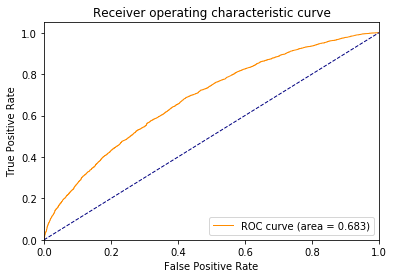

In [26]:
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=1, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
print('Test set ROC AUC: {}'.format(auc(fpr, tpr)))
plt.show()

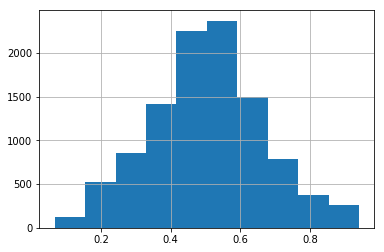

In [27]:
predicted = test_preds.reshape(-1)
pd.Series(predicted).hist()
plt.show()

In [28]:
df_acc = pd.DataFrame(columns=['minprob','maxprob','count','accuracy','lconf95','hconf95'])
for pbot in np.linspace(0,.9,10):
    ptop = pbot+.1
    mask = (predicted>=pbot)&(predicted<ptop)
    count = int(mask.sum())
    if count>0:
        actual = pd.Series(y_test)[mask].values
        pred_prob = pd.Series(predicted)[mask].values
        pred_bin = pred_prob>.5
        acc = accuracy_score(actual, pred_bin)
        nsucc = sum(actual==pred_bin)
        confint = proportion_confint(nsucc, count)
        minconf = confint[0]
        maxconf = confint[1]
    else:
        acc = np.nan
        minconf = np.nan
        maxconf = np.nan
    row = pd.DataFrame({'minprob':[pbot], 'maxprob':[ptop], 'count':[count], 
                        'accuracy':[acc], 'lconf95':[minconf], 'hconf95':[maxconf]})
    df_acc = pd.concat([df_acc, row], sort=False)
df_acc.set_index(['minprob','maxprob'])

,,count,accuracy,lconf95,hconf95
minprob,maxprob,,,,
0.0,0.1,26,0.961538,0.887619,1.000000
0.1,0.2,302,0.867550,0.829318,0.905781
0.2,0.3,837,0.729988,0.699911,0.760065
0.3,0.4,1391,0.670022,0.645312,0.694732
0.4,0.5,2513,0.547155,0.527693,0.566617
0.5,0.6,2663,0.546001,0.527091,0.564911
0.6,0.7,1553,0.638764,0.614873,0.662654
0.7,0.8,688,0.735465,0.702506,0.768424
0.8,0.9,421,0.843230,0.808500,0.877961


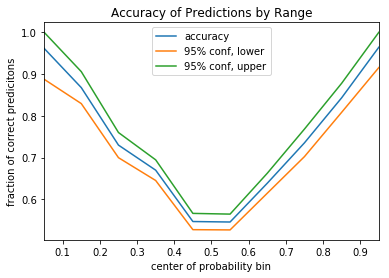

In [29]:
df_acc['avgprob'] = .5*(df_acc.minprob+df_acc.maxprob)
ax = df_acc.drop(['count','minprob','maxprob'],axis=1).set_index('avgprob').plot(
        title='Accuracy of Predictions by Range')
ax.legend(labels=['accuracy', '95% conf, lower', '95% conf, upper'])
ax.set(xlabel="center of probability bin", ylabel="fraction of correct predicitons")
plt.show()

In [30]:
model_file_name = 'not saved'
if do_save_model:
  model_file_name = basepath + 'USELModel_' + timestamp + '.h5'
  !cp USELModel_full.h5 '$model_file_name'
model_file_name

'/content/gdrive/My Drive/twitgen/USELModel_201908071556.h5'